In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import tensorflow_datasets as tfds
(raw_train, raw_validation, raw_test), metadata = tfds.load('oxford_flowers102', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], with_info=True, as_supervised=True)

In [ ]:
 print(raw_train)
 print(raw_validation)
 print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


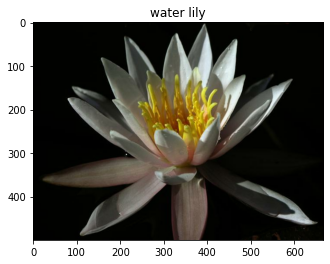

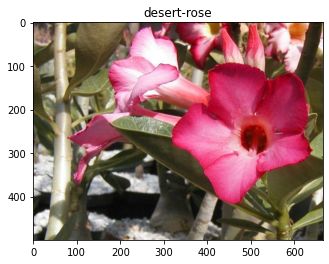

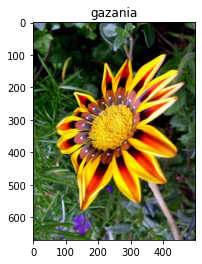

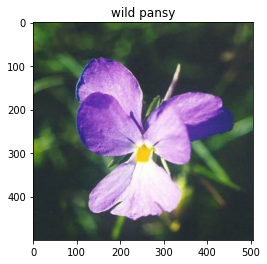

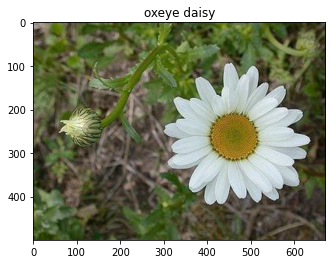

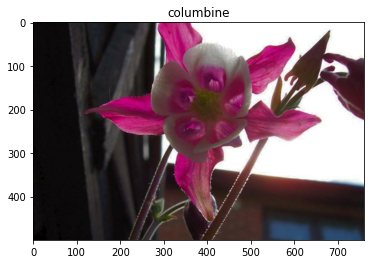

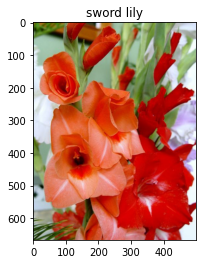

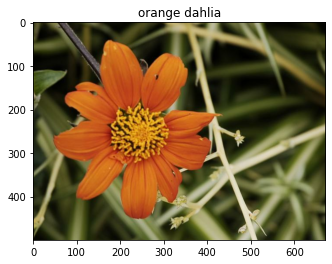

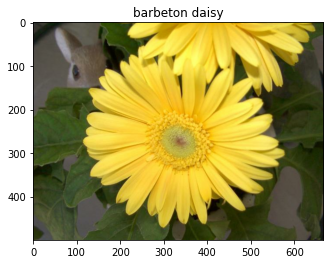

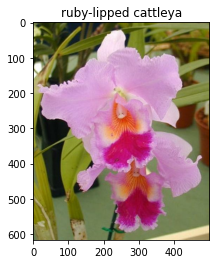

In [ ]:
# Display images from dataset
get_label_name = metadata.features['label'].int2str
for image, label in raw_train.take(10):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [ ]:
#Resize the images to a fixed input size, and rescale the input channels to a range of[-1,1]
IMG_SIZE = 160
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5)- 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
#Apply the function to each item in the dataset using the map method:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
# Shuffle and batch the data
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
# Inspecting a batch of data
for image_batch, label_batch in train_batches.take(1):
  pass
image_batch.shape

TensorShape([64, 160, 160, 3])

In [ ]:
# Model set up from a pre-trained convnet
IMG_SHAPE = (IMG_SIZE , IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [ ]:
# Using Feature extracter which converts each 160*160*3 image into a 5*5*1280 block
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


To prevent weights in layers from being changed during training, it is important to freeze the convolutional base before compiling and training the model.

In [ ]:
base_model.trainable = False

In [ ]:
# Setting up Model
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dropout(0.20),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(150, activation='relu'),
                             tf.keras.layers.Dropout(0.20),
                             tf.keras.layers.Dense(102, activation='softmax'),
])

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
dense (Dense)                (None, 5, 5, 256)         327936    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               960150    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 102)               1

In [ ]:
# Train Model
initial_epochs = 5
history = model.fit(train_batches, epochs=initial_epochs, validation_data=validation_batches)

Epoch 1/5
13/13 [==============================] - 7s 162ms/step - loss: 4.9229 - accuracy: 0.0086 - val_loss: 4.5110 - val_accuracy: 0.0294
Epoch 2/5
13/13 [==============================] - 2s 64ms/step - loss: 4.3280 - accuracy: 0.0551 - val_loss: 4.3711 - val_accuracy: 0.0490
Epoch 3/5
13/13 [==============================] - 2s 63ms/step - loss: 4.0254 - accuracy: 0.1066 - val_loss: 4.2104 - val_accuracy: 0.0686
Epoch 4/5
13/13 [==============================] - 2s 66ms/step - loss: 3.5846 - accuracy: 0.1887 - val_loss: 4.0318 - val_accuracy: 0.1275
Epoch 5/5
13/13 [==============================] - 2s 63ms/step - loss: 3.1803 - accuracy: 0.3027 - val_loss: 3.8192 - val_accuracy: 0.1471


In [ ]:
loss, accuracy = model.evaluate(train_batches)
print('\nTest accuracy before tuning:', accuracy)

13/13 [==============================] - 2s 36ms/step - loss: 2.3889 - accuracy: 0.6752

Test accuracy before tuning: 0.6752451062202454


## Fine Tuning:

In [ ]:
base_model.trainable = True

In [ ]:
# unfreeze thebase_modeland set the bottom layers to be un-trainable
print("Number of layers in the base model:",len(base_model.layers))
#Starting Fine tune
fine_tune_at = 100
# Freeze all the layers befor fine tune
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 154


In [ ]:
# Compile the model using a much lower learning rate
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
dense (Dense)                (None, 5, 5, 256)         327936    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               960150    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 102)               1

In [ ]:
# rained to convergence earlier, this step will improve your accuracy by a few percentage points
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_batches, epochs = total_epochs, initial_epoch = history.epoch[-1], validation_data=validation_batches)

Epoch 5/10
13/13 [==============================] - 9s 157ms/step - loss: 4.2653 - accuracy: 0.0846 - val_loss: 3.7005 - val_accuracy: 0.1961
Epoch 6/10
13/13 [==============================] - 3s 74ms/step - loss: 2.8572 - accuracy: 0.3517 - val_loss: 3.5685 - val_accuracy: 0.2647
Epoch 7/10
13/13 [==============================] - 3s 74ms/step - loss: 1.8301 - accuracy: 0.6213 - val_loss: 3.4387 - val_accuracy: 0.2451
Epoch 8/10
13/13 [==============================] - 3s 78ms/step - loss: 1.1354 - accuracy: 0.7831 - val_loss: 3.2733 - val_accuracy: 0.2843
Epoch 9/10
13/13 [==============================] - 3s 76ms/step - loss: 0.7245 - accuracy: 0.8860 - val_loss: 3.2144 - val_accuracy: 0.2745
Epoch 10/10
13/13 [==============================] - 3s 75ms/step - loss: 0.4110 - accuracy: 0.9412 - val_loss: 3.0709 - val_accuracy: 0.2941


In [ ]:
loss, accuracy = model.evaluate(train_batches)
print('\nTest accuracy after tuning :', accuracy)

13/13 [==============================] - 2s 36ms/step - loss: 1.1045 - accuracy: 0.7610

Test accuracy after tuning : 0.7610294222831726
